*Latex Commands*
$$\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}$$

In [1]:
%%html
<style>
    .inline {color : blue;
    }
    
    .top-ref {float : right;
    }
       
    .dropdown {
        position: relative;
        background-color: inherit;
        color: blue;
        display: flex;
    }
    
    ul.dropdown ul{
      list-style-type: none;
      padding: 0;
      margin: 0;
    }
    ul.dropdown ul ul{
      list-style-type: none;
      padding: 0;
      margin: 0;
    }
    
    .dropbtn {
      border: none;
      border-radius: 10px;
      outline: none;
      color: blue;
      padding: 14px 16px;
      background-color: #f0f0f0;
      font-family: inherit; /* Important for vertical align on mobile phones */
      margin: 0; /* Important for vertical align on mobile phones */
      transition: .15;
    }

    .dropdown ul{
      display: none;
      position: absolute;
      background-color: white;
      min-width: 160px;
      box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
      z-index: 1;
    }
    
    .dropdown1 ul{
      display: none;
    }
    
    .dropdown2 ul{
      display: none
    }
    
    .dropbtn:hover{
        background-color: grey;
        shadow: .15px .15px;
    }
    
    .dropdown li:hover{
        background-color: grey;
    }
    .dropbtn:hover .dropdown1{
        display: block;      
        position: absolute;
        padding: 0;
    }
    
    .dropdown2:hover .dropdown2{
      position: absolute;
      padding: 0;
      display: inline-block;
    }
    

    
</style>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, fsolve
from scipy.sparse import spdiags, linalg, eye
from scipy import tensordot
from tqdm import tqdm

plt.style.use('classic')
np.random.seed(0)

# Numerical Methods for Homogenization


<ul class="dropdown">
    <button class="dropbtn"> <a href="#Numerical-Methods-for-Homogenization"> Introduction</a>
    <ul class="dropdown1">
<div class="dropdown2">
            <li>
                <a href="#Finite-Difference-Schemes">Finite Difference Schemes</a>
            </li>
            <ul class="dropdown2">
                <li><a href="#Finite-Difference-Functions">Finite Difference Functions</a></li>
                <li><a href="#Finite-Difference-Matrices">Finite Difference Matrices</a></li>
                <li><a href="#PDE-Solvers">PDE Solvers</a></li>
            </ul>
        </div>        <div class="dropdown2">
            <li>
                <a href="#Design-Operations"> Design Operations </a>
            </li>
            <ul class="dropdown2">
                <li><a href="#Design-Laminates">Design Laminates</a></li>
                <li><a href="#Design-Matrix">Design Matrix</a></li>
                <li><a href="#Composite-Derivative-">Composite Derivative</a></li>
                <li><a href="#Derivative-wrt-Eigen-Vectors">Derivative wrt Eigen Vectors</a></li>
                <li><a href="#Derivative-wrt-Eigen-Directions">Derivative wrt Eigen Directions</a></li>
            </ul>
        </div>
        <li><a href="#Projected-Gradient-Algorithm">Projected Gradient Algorithm</a></li>
    </ul>
    </button>
    <button class="dropbtn"> <a href="#Heat-Lens">Heat Lens</a>
        <ul class="dropdown1">
            <div class="dropdown2">
                <li><a href="#Examples">Examples</a></li>
                <ul class="dropdown2">
                    <li>
                        <a href="#Example-1">Example 1</a>
                    </li>
                    <li>
                        <a href="#Example-2">Example 2</a>
                    </li>
                </ul>
            </div>
        </ul>
    </button>
        <button class="dropbtn"> <a href="#Heat-Lens">Optimal Transport</a>
    </button>
</ul>


**Homogenization Principles**

Consider the following ode

$$\begin{align*}
\nabla \cdot \left(\lambda \nabla u\right) &= f\\
\frac{\partial}{\partial n} \left(\lambda \nabla u\right)&=g(x),\quad x\in\partial\Omega_N\\
u&=h(x),\quad x\in\partial\Omega_D
\end{align*}$$

## Finite Difference Schemes

### Finite Difference Function

In [3]:
class FiniteDifferenceFunctions(metaclass=ABCMeta):
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(1,0),edge_order=2))#[::-1]
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=2))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

### Finite Difference Matrices

In [3]:
class FiniteDifferenceMatrices(metaclass=ABCMeta):
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self):
        n,m = self.n,self.m
        #X-MAT
        x_diag = np.diag(([-1]+[0]*(m-2)+[1])*(n),0)
        x_supdiag = np.diag(([1]+[.5]*(m-2)+[0])*(n-1)+([1]+[.5]*(m-2)),1)
        x_subdiag = np.diag(([-.5]*(m-2)+[-1]+[0])*(n-1)+([-.5]*(m-2)+[-1]),-1)
        x_mtrx = x_subdiag + x_diag + x_supdiag
        #Y-MAT
        y_diag = np.diag([-1]*m+[0]*m*(n-2)+[1]*m,0)
        y_supdiag = np.diag([1]*m+[.5]*m*(n-2),m)
        y_subdiag = np.diag([-.5]*m*(n-2)+[-1]*m,-m)
        y_mtrx = y_subdiag + y_diag + y_supdiag
        return np.array([x_mtrx/self.dx,y_mtrx/self.dy])
    def div(self):
        return np.moveaxis(self.grad(),0,-1)
    def divGrad(self):
        return np.tensordot(self.div(),self.grad(),axes=([2,1],[0,1]))
    def Agrad(self):
        assert (self.A is not None)
        A = self.A.reshape([2,2,self.m*self.n])
        mult = lambda A,v: np.einsum('ijk,jkl->ikl',A,v)
        return mult(A,self.grad())
    def divAgrad(self):
        assert (self.A is not None)
        A = self.A.reshape([2,2,self.m*self.n])
        mult = lambda A,v: np.einsum('ijk,jkl->ikl',A,v)
        return np.tensordot(self.div(),mult(A,self.grad()),axes=([2,1],[0,1]))

### PDE Solvers

In [ ]:
class PDESolvers(metaclass=ABCMeta):
    def __init__(self):
        pass

## Design Operations

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

### Design Laminates
$$\begin{align*}
\lambda_- &= \bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-1}\\[2ex]
\lambda_+ &= \alpha\theta+\beta(1-\theta)
\end{align*}$$

In [4]:
def genLam(theta,shape,alpha=1,beta=.5):
    lamMinus=np.ma.power(theta/alpha+(np.ones(shape)-theta)/beta,-1)
    lamPlus=alpha*theta+beta*(np.ones(shape)-theta)
    return lamMinus,lamPlus

### Design Matrix

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>


$$\begin{align*}
A^* &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \lambda_+ & 0\\ 0 & \lambda_-\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\[2ex]
&=\begin{pmatrix}
\lambda_+\cos^2(\phi)+\lambda_-\sin^2(\phi) & (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi)
\\ (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi) & \lambda_+\sin^2(\phi)+\lambda_-\cos^2(\phi)
\end{pmatrix}\end{align*}$$

In [5]:
def genA(theta,phi,shape,alpha=1,beta=.1):
    A = np.zeros([2,2]+shape)
    lamPlus,lamMinus=genLam(theta,shape,alpha,beta)
    #BLOCK A
    for i in range(shape[0]):
        for j in range(shape[1]):
            A1=lamPlus[i,j]*np.cos(phi[i,j])**2+lamMinus[i,j]*np.sin(phi[i,j])**2
            A2=(lamPlus[i,j]+lamMinus[i,j])*np.sin(phi[i,j])*np.cos(phi[i,j])
            A3=lamPlus[i,j]*np.sin(phi[i,j])**2+lamMinus[i,j]*np.cos(phi[i,j])**2
            A[...,i,j]=np.array([[A1,A2],[A2,A3]])
    return A

### Composite Derivative

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

$$\begin{align*}
\frac{\partial\lambda_-}{\partial\theta} &= -\bigg(\frac{1}{\alpha} - \frac{1}{\beta}\bigg)\bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-2}\\
\frac{\partial\lambda_+}{\partial\theta} &= \alpha-\beta\\
\end{align*}$$

In [6]:
def lam_theta(theta,shape,alpha=1,beta=.5):
    n,m=shape
    lamMinus_theta =-np.ma.power((1/alpha-1/beta)*(theta/alpha+(np.ones(n,m)-theta)/beta),-2)
    lamPlus_theta=alpha*theta+beta*(np.ones(n,m)-theta)
    return lamPlus_theta,lamMinus_theta

### Derivative wrt Eigen Vectors

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

$$\begin{align*}
\frac{\partial A}{\partial\theta} &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \frac{\partial\lambda_+}{\partial\theta} & 0\\ 0 & \frac{\partial\lambda_-}{\partial\theta}\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
\end{align*}$$

In [7]:
def A_theta(thetaK,phiK,alpha=1,beta=.1):
    lamMinus_theta=-(1/alpha-1/beta)*((thetaK/alpha+(1-thetaK)/beta)**(-2))
    lamPlus_theta=alpha-beta

    A1=lamPlus_theta*np.cos(phiK)**2+lamMinus_theta*np.sin(phiK)**2
    A2=(-lamPlus_theta+lamMinus_theta)*np.sin(phiK)*np.cos(phiK)
    A3=lamPlus_theta*np.sin(phiK)**2+lamMinus_theta*np.cos(phiK)**2
  
    A_theta=np.array([[A1,A2],[A2,A3]])
    return A_theta

### Derivative wrt Eigen Directions

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

$$\begin{align*}
\frac{\partial A}{\partial\phi} &= \begin{pmatrix} (-\lambda_++\lambda_-)(2\cos(\phi)\sin(\phi)) & (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi))
\\ (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi)) & (\lambda_+-\lambda_-)(2\cos(\phi)\sin(\phi)) \end{pmatrix}\end{align*}$$

In [8]:
def A_phi(thetaK,phiK,alpha=1,beta=.1):
    lamPlus=np.ma.power(thetaK/alpha+(1-thetaK)/beta,-1)
    lamMinus=alpha*thetaK-beta*(1-thetaK)

    A1=(-lamPlus+lamMinus)*2*np.sin(phiK)*np.cos(phiK)
    A2=(-lamPlus+lamMinus)*(np.cos(phiK)**2-np.sin(phiK)**2)
    A3=(lamPlus-lamMinus)*2*np.sin(phiK)*np.cos(phiK)

    A_phi=np.array([[A1,A2],[A2,A3]])
    return A_phi

## Projected Gradient Algorithm

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

* Solve $u$

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_2} &= 1\\
u\vert_{\Gamma_3}&=0
\end{align*}$$

* Solve $p$

$$\begin{align*}
\nabla \cdot (A^* \nabla p) &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_2} &= 0\\
p\vert_{\Gamma_3}&=\rho
\end{align*}$$


* Update $\theta$
$$\begin{align*}
\theta_{k+1} = \max \bigg( 0,\min \bigg(1,\theta_k-t_k\bigg(\ell_k+\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\bigg) \bigg)\bigg)\end{align*}$$

* Update $\phi$
$$\begin{align*}
\phi_{k+1} = \phi_k-t_k\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\end{align*}$$

***

## Heat Lens

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

**Primal**

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_2} &= 1\\
u\vert_{\Gamma_3}&=0
\end{align*}$$

**Dual**

$$\begin{align*}
\nabla \cdot (A^* \nabla p) &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_2} &= 0\\
p\vert_{\Gamma_3}&=\rho
\end{align*}$$

In [9]:
class heatLens():
    def __init__(self,x,y,options={}):
        #DOMAIN
        self.m=len(x)
        self.n=len(y)
        self.dx = 1/(m+1)
        self.dy = 1/(n+1)
        self.domain_len = self.m*self.n
        self.domain_shape = (self.m,self.n)
        self.xx, self.yy = np.meshgrid(x,y)
        self.zeros = np.zeros(self.domain_shape)
        self.ones = np.ones(self.domain_shape)
        #BOUNDARIES
        self.x_loc = np.zeros(self.domain_shape);
        self.x_loc[0,:]=np.ones(m);self.x_loc[-1,:]=np.ones(m);
        self.y_loc = np.zeros(self.domain_shape);
        self.y_loc[:,0]=np.ones(n);self.y_loc[:,-1]=np.ones(n)
        self.interior = np.ones(self.domain_shape);
        self.interior[0,:]=np.zeros(m);self.interior[-1,:]=np.zeros(m);
        self.interior[:,0]=np.zeros(n);self.interior[:,-1]=np.zeros(n)
        #OPTIONS
        self.options=options
        self.check_options()
        #PRIMAL BOUNDARY DATA
        self.gamma_loc = np.diag(self.options['gamma_loc'].reshape(domain_len))
        self.gamma_nloc = np.eye(domain_len)-self.gamma_loc
        self.rho_loc = np.diag(self.options['rho_loc'].reshape(domain_len))
        self.rho_yloc = np.diag(self.x_loc.reshape(domain_len))*self.rho_loc
        self.rho_xloc = np.diag(self.y_loc.reshape(domain_len))*self.rho_loc
        self.rho_nloc = np.eye(domain_len)-self.rho_loc
        self.gamma =self.options['gamma'].reshape(domain_len)
        self.rho = self.options['rho'].reshape(domain_len)
        #INITIALIZE
        self.u=np.zeros(self.domain_len)
        self.p=np.zeros(self.domain_len)
        self.theta=np.ones(self.domain_shape)#np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.phi=np.zeros(self.domain_shape)#np.pi*np.random.rand(self.domain_len).reshape(self.domain_shape)#
        self.lv=self.options['lv']
        self.vol=self.options['volume']
        #DIFFERENCES
        self.fdf = FiniteDifferenceFunctions(self.m,self.n,self.dx,self.dy)
        self.fdm = FiniteDifferenceMatrices(self.m,self.n,self.dx,self.dy)
        self.contract = lambda a,b,c : np.einsum('ijk,ijk->jk',b,
                        np.einsum('ijkl,jkl->ikl',a,c))

    def iterate(self,k):
        pbar = tqdm(range(k))
        for _ in pbar:
            self._iter()
            pbar.set_description(desc=str(self.lv))

    def _iter(self):
        #INITIALIZE
        alpha=self.options['alpha']
        beta=self.options['beta']
        tk=self.options['tk']
        #COEFFICIENTS
        A=genA(self.theta,self.phi,[self.m,self.n],alpha=alpha,beta=beta)
        self.fdm.A = A
        self.fdf.A = A
        #PRIMAL SOLUTION VIA RESIDUAL
        primal = (self.gamma_nloc*self.rho_nloc*(self.fdm.divAgrad())
                                  +self.rho_xloc*(self.fdm.Agrad()[0]) #NEUMANN dx
                                  +self.rho_yloc*(self.fdm.Agrad()[1]) #NEUMANN dy
                                  +self.gamma_loc) #DIRICHLET
        print(self.rho.shape)
        f_primal = self.rho.reshape(domain_len)
        u = np.linalg.lstsq(primal,f_primal)[0]
        Du = self.fdf.grad(u)     
        #ADJOINT SOLUTION VIA RESIDUAL
        adjoint = (self.gamma_nloc*self.rho_nloc*(self.fdm.divAgrad())
                                  +self.rho_xloc*(self.fdm.Agrad()[0]) #NEUMANN dx
                                  +self.rho_yloc*(self.fdm.Agrad()[1]) #NEUMANN dy
                                  +self.gamma_loc) #DIRICHLET
        f_adjoint = self.gamma
        p = np.linalg.lstsq(adjoint,f_adjoint)[0]
        Dp = self.fdf.grad(p) 
        for i in range(self.m):
            for j in range(self.n):
                A_t=A_theta(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                rhs=self.theta[i,j]-tk*(self.lv+A_t@Du[:,i,j]@Dp[:,i,j])
                self.theta[i,j]=max([0,min([1,rhs])])
        for i in range(self.m):
            for j in range(self.n):
                A_p=A_phi(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                self.phi[i,j]=self.phi[i,j]-tk*(A_p@Du[:,i,j]@Dp[:,i,j])

        #SOLUTION DATA
        self.u = u
        self.p = p
        self.Du = Du
        self.Dp = Dp
        self.ADu=self.fdf.Agrad(u)
        self.ADp=self.fdf.Agrad(p)
        self.sol=self.fdf.divAgrad(u)

    def check_options(self):
        assert ('gamma' in self.options) and ('gamma_loc' in self.options), 'No Dirichlet Conditions Provided.'
        assert ('rho' in self.options) or ('rho_loc' in self.options), 'No Sources Provided.'
        if not('alpha' in self.options):
            self.options['alpha']=.1
        if not('beta' in self.options):
            self.options['beta']=1
        if not('tk' in self.options):
            self.options['tk']=.1
        if not('lv' in self.options):
            self.options['lv']=0
        if not('volume' in self.options):
            self.options['volume']=.5

### Example 1

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

In [10]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [11]:
rho = np.zeros(domain_shape)
rho[-1,1:-1] = -np.ones(m-2)
rho_loc = np.zeros(domain_shape)
rho_loc[:,-1] = np.ones(n)
rho_loc[:,0] = np.ones(n)
rho_loc[-1,1:-1] = np.ones(n-2)
gamma_loc = np.zeros(domain_shape)
gamma_loc[0,:] = np.ones(n)
gamma = np.zeros(domain_shape)
gamma[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':0, 'volume':.75,
         'rho':rho,'gamma':gamma,
         'rho_loc':rho_loc,'gamma_loc':gamma_loc}
prob = heatLens(x,y,options)

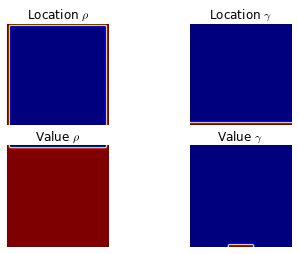

In [12]:
plt.subplot(221)
plt.title('Location $\\rho$')
plt.imshow(np.diag(prob.rho_loc).reshape(domain_shape)[::-1])
plt.axis('off')
plt.subplot(222)
plt.title('Location $\\gamma$')
plt.imshow(np.diag(prob.gamma_loc).reshape(domain_shape)[::-1])
plt.axis('off')
plt.subplot(223)
plt.title('Value $\\rho$')
plt.imshow(prob.rho.reshape(domain_shape)[::-1])
plt.axis('off')
plt.subplot(224)
plt.title('Value $\\gamma$')
plt.imshow(prob.gamma.reshape(domain_shape)[::-1])
plt.axis('off')
plt.show()

In [13]:
prob.iterate(10)

  0%|                                                                                       | 0/10 [00:00<?, ?it/s]

(1600,)


/tmp/ipykernel_2140/1800917930.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u = np.linalg.lstsq(primal,f_primal)[0]
/tmp/ipykernel_2140/1800917930.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(adjoint,f_adjoint)[0]
0:  10%|███████▌                                                                    | 1/10 [00:02<00:24,  2.69s/it]

(1600,)


0:  20%|███████████████▏                                                            | 2/10 [00:05<00:20,  2.60s/it]

(1600,)


0:  20%|███████████████▏                                                            | 2/10 [00:07<00:31,  3.99s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
Du = np.divide(prob.Du,np.fmax(1,np.linalg.norm(prob.Du, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],Du[0][1:-1],Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
Dp = np.divide(prob.Dp,np.fmax(1,np.linalg.norm(prob.Dp, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],Dp[0][1:-1],Dp[1][1:-1])
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],cmap='grey',vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(121)
ADu = np.divide(prob.ADu,np.fmax(.1,np.linalg.norm(prob.ADu, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],ADu[0][1:-1],ADu[1][1:-1])
plt.title('$A\\nabla u$')
plt.subplot(122)
plt.title('$A\\nabla p$')
ADp = np.divide(prob.ADp,np.fmax(.1, np.linalg.norm(prob.ADp, axis=0)))
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],ADp[0][1:-1],ADp[1][1:-1])
plt.show()

In [ ]:
print(prob.ADu[0][:,-1])
print(prob.ADu[0][:,0])
print(prob.ADu[1][-1,:])
print(prob.ADp[1][-1,:])

### Example 2

<a href="#Numerical-Methods-for-Homogenization" class="top-ref">[top]</a>

In [ ]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [ ]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-m//4:-1,0] = -np.ones(m//4-1)
neumann_bcs[1,-m//4:-1,-1] = -np.ones(m//4-1)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:-1,-1] = np.ones(n-1)
neumann_loc[0,:-1,0] = np.ones(n-1)
neumann_loc[1,-1,:] = np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':1, 'volume':.75,
         'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,
         'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,options)

In [ ]:
plt.subplot(121)
plt.title('Dirichlet Location')
plt.imshow(prob.dirichlet_loc[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Dirichlet Condition')
plt.imshow(prob.dirichlet_bcs[::-1])
plt.axis('off')
plt.show()

In [ ]:
plt.subplot(121)
plt.title('Neumann Location')
plt.imshow((prob.neumann_loc[0]+prob.neumann_loc[1])[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Neumann Condition')
plt.imshow((prob.neumann_bcs[0]+prob.neumann_bcs[1][::-1]),vmax=1,vmin=-1)
plt.axis('off')

In [ ]:
prob.iterate(10)

In [ ]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Du[0][1:-1],prob.Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Dp[0][1:-1],prob.Dp[1][1:-1])
plt.colorbar()
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()